# 1. Brief Introduction of IAT
The **Implicit Association Test (IAT)** is a psychological tool devised in the 1990s to uncover unconscious biases pertaining to race, gender, age, among other factors. It measures the strength of an individual's automatic associations between mental representations stored in memory. The IAT gauges these biases by examining the rapidity with which individuals can pair words and images, based on the premise that **swifter responses denote stronger associations**. This tool is crucial for delving into **subconscious beliefs and biases**, facilitating personal introspection, and encouraging discussions on systemic issues such as racism and sexism. Moreover, it supports organizations in crafting diversity, equity, and inclusion initiatives by shedding light on potential unconscious biases present in various contexts.

## 1.1 Experiment Design
In this experiment, our objective was to replicate the **implicit self-esteem effect**(蔡华俭, 2003) literature, where associations pairing **"self-positive" and "other-negative"** words exhibit greater potency compared to associations that pair "self-negative" and "other-positive" words. The experiment, as outlined by Greenwald and Farnham in 2000, comprised five main sections:

| Step | Type     | Explanation                               | Trials N |                Binding                |
|------|----------|-------------------------------------------|:--------:|:-------------------------------------:|
| 1    | Practice | Associative attribute word discrimination |    20    |           I(self); E(other)           |
| 2    | Practice | Initial target word discrimination        |    20    |       I(positive); E(negative)        |
| 3    | Practice | Initial joint discrimination              |    20    | I(positive, self); E(negative, other) |
| 3    | Test     | Initial joint discrimination              |    40    | I(positive, self); E(negative, other) |
| 4    | Practice | Opposite target word discrimination       |    20    |       I(negative); E(positive)        |
| 5    | Practice | Opposite joint discrimination             |    20    | I(negative, self); E(positive, other) |
| 5    | Test     | Opposite joint discrimination             |    40    | I(negative, self); E(positive, other) |

Step 3 and 5 incorporated an additional practice block each, bringing the total number of blocks in the experiment to seven. The sequence in which these blocks were presented **fell into two categories**: 
1. 1-2-3 (with a practice block) - 4-5 (with a practice block)
2. 1-4-5 (with a practice block) - 2-3 (with a practice block)

Each trial initiated with an unspecified inter-trial interval (0.1, 0.4 or 0.7s) preceding the stimulus presentation, followed by the stimulus displayed without a time constraint until the participant executed a keystroke. Notably, **feedback** was furnished exclusively within the **practice** blocks.
<p style="text-align:center;"> 
<img src="Pictures/IAT_Procedure.png" alt="Mental Rotation Procedure" width="960" />
</p>

## 1.2 Work Flow
In the current Jupyter notebook, we began by merging the individual data files for each subject. We then implemented basic quality control by ensuring the correctness rate exceeded a specified threshold. Following this, we calculated the reaction times and error rates for each subject at various angles. Lastly, we visually represented this data through graphs and conducted statistical analysis to test our hypothesis. 

**Note**: Citation was attached in the last section of this notebook.

In [1]:
# Imports
from pathlib import Path
## Data, plot and statistical model
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pingouin as pg
## Suppress future warnings
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = '10'
plt.style.use('seaborn-v0_8-pastel')

# 2. Data Preparation
Within the "Data" folder, various subfolders house data collected from different platforms. This data was consolidated into a single dataframe object. Subsequently, we tallied the number of subjects contributing data from each platform.

In [2]:
from_folder = Path('Data/IAT')
# Combine subject data to a dataframe and then add their group and id
data = []
for file in from_folder.rglob('*.csv'):
    datum = pd.read_csv(file)
    datum['sub_id'] = file.stem
    datum['group'] = file.parent.stem.split('_')[0]
    data.append(datum)
data = pd.concat(data)

# Create a {sub_id: group} mapping
mapping = data.drop_duplicates('sub_id').set_index('sub_id')['group'].to_dict()
# The number of each group
raw_subject_n = data.drop_duplicates(subset=['sub_id']).groupby('group')['sub_id'].count()
raw_subject_n.name = 'raw count'
print('The following illustrates the number of participants from each group:')
raw_subject_n

The following illustrates the number of participants from each group:


group
Naodao      35
Offline     35
Pavlovia    35
Name: raw count, dtype: int64

## 2.1 Brief Explanation of Data Columns
Each row represents a trial undertaken by a specific subject. The columns are defined as follows:
- **corr**: *correctness*. Indicates whether the response in the current trial was correct, denoted as 1, or incorrect, denoted as 0.
- **rt**: *response time*. The time, in seconds, taken by the subject to respond.
- **sub_id**: *subject ID*. The unique identifier for the subject participating in the trial.
- **group**: Represents the platform where the subjects participated in the experiment. The possible values are:
    - Naodao: Referring to the [Naodao Research Platform](https://www.naodao.com).
    - Pavlovia: Referring to the [Pavlovia platform](https://pavlovia.org).
    - Offline: Denoting subjects recruited at the offline lab at Beijing Normal University.
- **block_type**: *block type*, indicating the 5 section of the IAT procedure.
- **trial_type**: *trial type*, either "practice" or "test".


In [3]:
data

,corr,rt,block_type,trial_type,sub_id,group
0,1.0,0.5723,step1,practice,001,Naodao
1,1.0,0.6178,step1,practice,001,Naodao
2,0.0,0.5134,step1,practice,001,Naodao
3,1.0,0.6365,step1,practice,001,Naodao
4,1.0,0.4691,step1,practice,001,Naodao
...,...,...,...,...,...,...
175,1.0,0.6994,step5,test,105,Pavlovia
176,1.0,0.6183,step5,test,105,Pavlovia
177,1.0,0.5724,step5,test,105,Pavlovia
178,1.0,0.6674,step5,test,105,Pavlovia


# 3. Quality Control
We conducted basic quality control on the data, **eliminating** subjects with a **correctness rate below 80%** and a **mean response time exceeding 3 seconds**. Consequently, no subjects were removed from the offline group and Naodao group, while one  was removed from the Pavlovia group.

In [4]:
response_quality = data.groupby(['sub_id'])[['corr', 'rt']].mean()
response_quality.columns = ['corr_rate', 'MnRT']
data = (data
        .merge(response_quality.reset_index(), on='sub_id')
        .query('(corr_rate >= 0.8) & (MnRT <= 2.5)')
        .drop(columns=['corr_rate', 'MnRT']))
clean_subject_n = data.drop_duplicates(subset=['sub_id']).groupby('group')['sub_id'].count()
clean_subject_n = pd.DataFrame(clean_subject_n)
clean_subject_n.columns = ['after clean']
clean_subject_n['before clean'] = raw_subject_n
print('The following illustrates the number of participants from each group:')
clean_subject_n

The following illustrates the number of participants from each group:


,after clean,before clean
group,,
Naodao,35,35
Offline,35,35
Pavlovia,34,35


# 4. Measurement Calculation
To ensure our approach mirrored that of the original research (Cai, 2003), we employed the data analysis methods specified in that study. Initially, we assessed the response times recorded in steps 3 and 5, modifying any times below 0.3 seconds to 0.3 seconds, and those exceeding 3 seconds to 3 seconds. Following this, we separately computed the mean of these revised response times; the average time from step 3 designated the congruent reaction time, whereas the average from step 5 represented the incongruent reaction time.

In [5]:
data = data[data['block_type'].isin(["step3", "step5"])].copy()
data['MnRT'] = np.clip(data['rt'], a_min=0.3, a_max=3)
plot_data = data.groupby(['sub_id', 'block_type'])['MnRT'].mean().reset_index()
plot_data['group'] = plot_data['sub_id'].map(mapping)
plot_data['type'] = plot_data['block_type'].map({'step3': 'Congruent', 'step5': 'Incongruent'})
plot_data = plot_data.drop(columns=['block_type'])
plot_data.to_csv('Data/IAT.csv', index=False)

## 4.1 Brief Explanation of Data Columns
In addition to the variables introduced in section 2.1, we have incorporated the following:
- **MnRT**: Mean Response Time. The average response time for each subject, measured at different steps.
- **type**: Type of Mean Response Time. Either "Congruent" or "Incongruent."

In [6]:
plot_data

,sub_id,MnRT,group,type
0,001,0.773785,Naodao,Congruent
1,001,0.931838,Naodao,Incongruent
2,002,0.758280,Naodao,Congruent
3,002,0.857187,Naodao,Incongruent
4,003,0.888510,Naodao,Congruent
...,...,...,...,...
203,103,0.856368,Pavlovia,Incongruent
204,104,0.595363,Pavlovia,Congruent
205,104,0.802572,Pavlovia,Incongruent
206,105,0.571512,Pavlovia,Congruent


# 4. Plots
Visualizations can enhance the comprehension of the results. These images can be found in the "Pictures" folder.

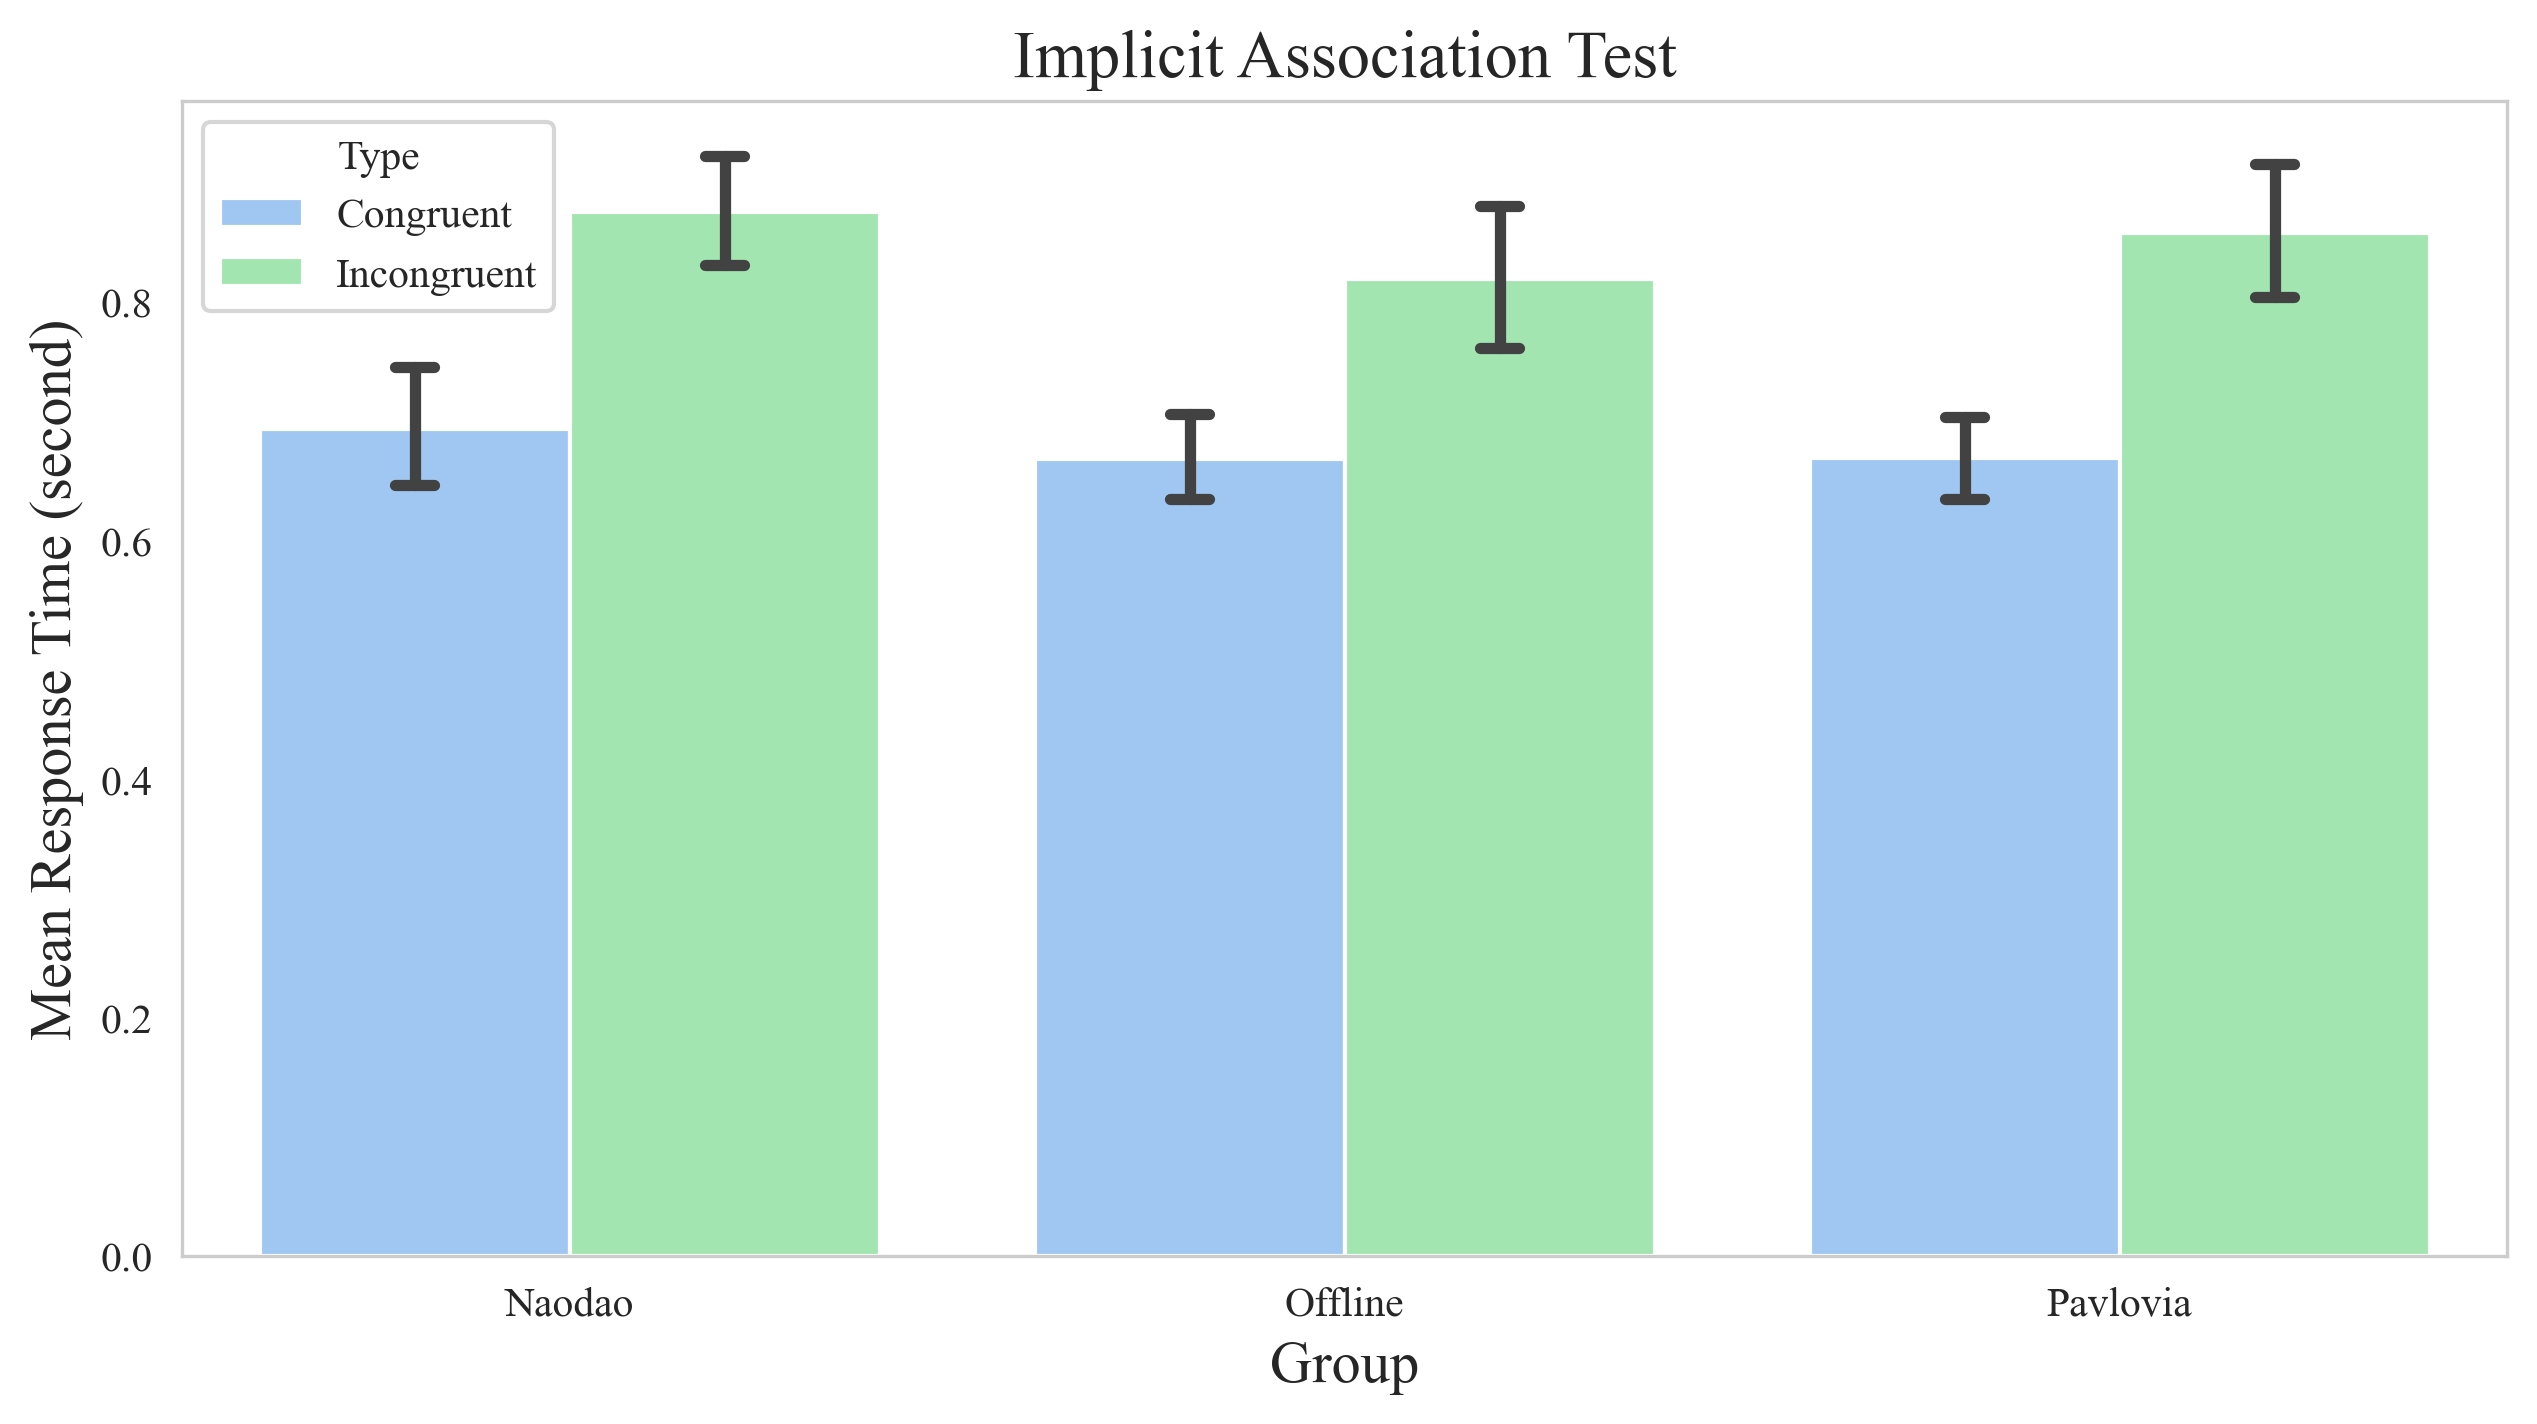

In [7]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
plt.grid(False)
sns.barplot(data=plot_data, x='group', y='MnRT', hue='type', capsize=0.05, ax=ax)
ax.set_ylabel('Mean Response Time (second)', fontsize=14)
ax.set_xlabel('Group', fontsize=14)
ax.legend().set_title('Type')
ax.set_title('Implicit Association Test')
ax.title.set_size(16)
fig.savefig('Pictures/IAT_Result.png')

# 5. Statistical Analysis

The central hypothesis of the IAT hinges on the anticipation of higher scores in compatible responses compared to incompatible ones. To test this, we employed paired-samples t-tests and ANOVAs.

## 5.1 Effect Replication

As our initial step, we aimed to corroborate the reproduction of the conventional effect in each group, utilizing paired-sample t-tests for this validation process. Each column in the dataset carries specific implications, explained as follows:
- for paired t test:
    - **T**: *T-value*
    - **dof**: *degrees of freedom*
    - **p-val**: *p-value*
    - **cohen-d**: *Cohen d effect size*
    - **BF10**: *Bayes Factor of the alternative hypothesis*
- for mixed ANOVA:
    - **ddof1**: *Degrees of freedom (numerator)*
    - **ddof2**: *Degrees of freedom (denominator)*
    - **F**: *F-value*
    - **p-unc**: Uncorrected p-value*
    - **ng2**: *Generalized eta-square effect size*

You can refer to the [pg.ttest](https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest) section of the Pingouin Python package documentation for a deeper understanding of these terms.

Through this analytical lens, we **replicated of the classic IAT effect in various groups**(*p*s < .0001). Remarkably, the effect sizes manifested consistently across different groups, largely aligning with the values documented in prior literature. For a straightforward comparison, we resorted to using the **Cohen's D** derived from the cited research by Cai in 2003. The analysis of the mean response time indicated that our data fluctuated within a range of **1.03 to 1.34**, staying in proximity to the **0.88** benchmark cited in the literature. This slight deviation might be a byproduct of different sampling dynamics such as racial diversity, age distribution, or the nature of the materials utilized in the study.

In [8]:
result_list = []
for group in plot_data['group'].unique():
    this_data = plot_data.query(f'group == "{group}"')
    # Perform paired t-test analysis and the select columns (for simplicity)
    result = pg.ttest(
        x=this_data.query('type == "Incongruent"')['MnRT'],
        y=this_data.query('type == "Congruent"')['MnRT'],
        paired=True, alternative='greater').round(5)
    result = result[['T', 'dof', 'p-val', 'cohen-d', 'BF10']]
    result.insert(0, 'group', group)
    result_list.append(result)
pd.concat(result_list)

,group,T,dof,p-val,cohen-d,BF10
T-test,Naodao,6.19589,34,0.0,1.27273,6.868e+04
T-test,Offline,7.74545,34,0.0,1.02900,4.792e+06
T-test,Pavlovia,7.32442,33,0.0,1.34723,1.299e+06


## 5.2 Comparison Between Groups
Next, we plan to pinpoint any notable differences between the various groups by employing mixed ANOVA. In this methodology, the **type** of mean response time acts as the **within-subject** independent variable, while the **group** categorization operates as the **between-subject** independent variable.

The results show **no significant group effect nor interaction effect** between group and type of mean response time (*p* values > 0.39). Even if such effects were significant, they would be deemed insubstantial, with **effect sizes ranging from 0.003 to 0.014**, as categorized by Cohen's 1998 delineation of effect sizes (Cohen, 2013).

In [9]:
# For MnRT
result = plot_data.mixed_anova(dv='MnRT', subject='sub_id', within='type', between='group', effsize='ng2').round(5)
result[['Source', 'DF1', 'DF2', 'F', 'p-unc', 'ng2']]

,Source,DF1,DF2,F,p-unc,ng2
0,group,2,101,0.95197,0.38942,0.01361
1,type,1,101,142.58400,0.00000,0.27446
2,Interaction,2,101,0.63098,0.53416,0.00334


# References
- 蔡华俭. (2003). 内隐自尊效应及内隐自尊与外显自尊的关系. 心理学报, 35(6), 796~801.
- Cohen, J. (2013). Statistical power analysis for the behavioral sciences. Academic press.
- Greenwald, A. G., & Farnham, S. D. (2000). Using the implicit association test to measure self-esteem and self-concept. Journal of personality and social psychology, 79(6), 1022.